In [103]:
# %load main.py
import sys
import importlib

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt

from armax import armax
from config import config
import mysql_utils as mysql
import visualization

In [2]:
#DETECTOR_DATA_TABLE = "detector_data_processed_2017_1"
DETECTOR_DATA_TABLE = "detector_data_processed_2017"
DETECTOR_ID = "608219"
DETECTOR_DATA_QUERY = "SELECT DetectorID, Year, Month, Day, Time, Volume, Occupancy\
                        FROM {} AS DD NATURAL JOIN detector_health AS DH\
                        WHERE DetectorID = {} AND Health = 1\
                        ORDER BY Year, Month, Day, Time;".format(DETECTOR_DATA_TABLE, DETECTOR_ID)

In [3]:
def query_detector_data(cursor, table, detector_id, graph=False):
    query = DETECTOR_DATA_QUERY.format(table, detector_id)

    cursor = mysql.query(cursor, query)
    
    if cursor == None:
        return

    time = []
    volume = []
    occupancy = []
    #speed = []

    for row in cursor:
        d = dt.datetime(row[1], row[2], row[3], row[4] // 3600, (row[4] % 3600) // 60, row[4] % 60)
        time.append(d)

        volume.append(row[5])
        occupancy.append(row[6])
        #speed.append(row[7])

    time = np.array(time)
    volume = np.array(volume)
    occupancy = np.array(occupancy)
    occupancy_percentage = occupancy / 3600 * 100
    #speed = np.array(speed)

    if graph:
        visualization.plot_data_over_time(time, volume, title="Detector {} Volume January 2017".format(detector_id), ylabel="Volume (vph)", figsize=(12, 5))
        visualization.plot_data_over_time(time, occupancy, title="Detector {} Occupancy January 2017".format(detector_id), ylabel="Occupancy (s)", figsize=(12, 5))
        #visualization.plot_data_over_time(time, speed, title="Detector {} Speed January 2017".format(detector_id), ylabel="Speed", figsize=(12, 5))
        visualization.plot_data_over_time(time, occupancy_percentage, title="Detector {} Occupancy January 2017".format(detector_id), ylabel="Occupancy (%)", figsize=(12, 5))
        visualization.plot_fundamental_diagram(volume, occupancy_percentage, title="Detector {} Flow-Occupancy Diagram January 2017".format(detector_id))

    return time, volume, occupancy

In [4]:
cnx = mysql.connect_to_database(**config)

if cnx == None:
    sys.exit()

cursor = cnx.cursor()

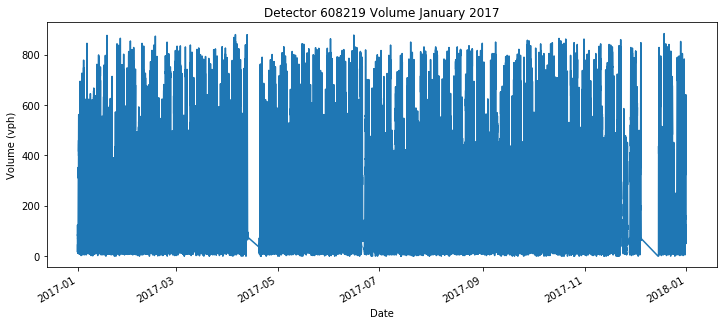

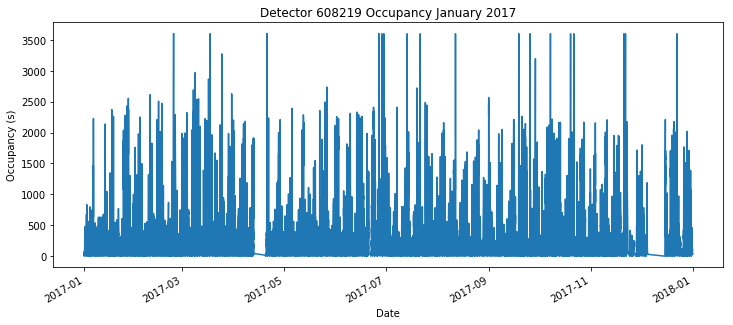

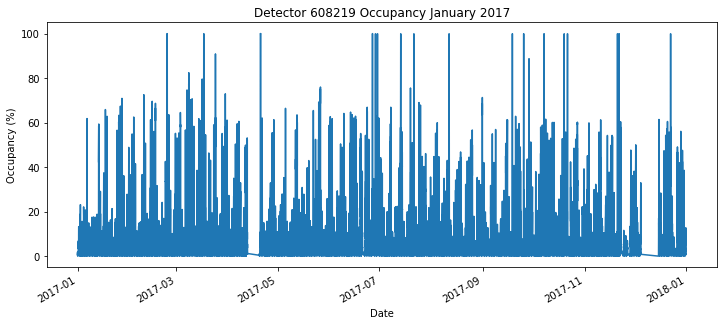

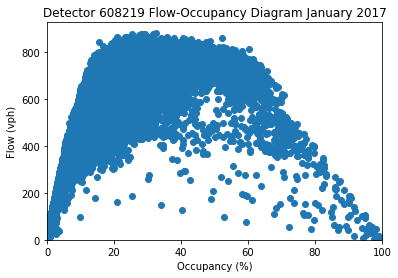

In [5]:
time, flow, occupancy = query_detector_data(cursor, DETECTOR_DATA_TABLE, DETECTOR_ID, graph=True)

In [105]:
armax_model = armax(flow, dates=time)

In [ ]:
d1 = dt.datetime.now()
results = armax_model.fit_to_order((1, 1), method="css", verbose=True)
d2 = dt.datetime.now()
print("Time elapsed:")
print((d2 - d1).total_seconds())

d1 = dt.datetime.now()
results = armax_model.fit_to_order((1, 1), method="css-mle", verbose=True)
d2 = dt.datetime.now()
print("Time elapsed:")
print((d2 - d1).total_seconds())

d1 = dt.datetime.now()
results = armax_model.fit_to_order((1, 1), method="mle", verbose=True)
d2 = dt.datetime.now()
print("Time elapsed:")
print((d2 - d1).total_seconds())

Fitting order (1, 1)
Time elapsed:
25.626852
Fitting order (1, 1)


In [106]:
armax_model.fit(method="css", verbose=True)

Fitting order (1, 1)
Order (1, 1) sse: 40811786.39866703
Fitting order (1, 2)
Order (1, 2) sse: 37726869.39251242
Fitting order (1, 3)
Order (1, 3) sse: 35790077.12937783
Fitting order (2, 1)
Order (2, 1) sse: 38996393.251613975
Fitting order (2, 2)
Order (2, 2) sse: 36142151.85075931
Fitting order (2, 3)


KeyboardInterrupt: 

In [93]:
for order in armax_model._armax_models:
    m = armax_model._armax_models[order]
    print(order)
    print(m.aic)
    print(m.bic)
    print(np.sum(np.power(m.resid, 2)))

(1, 1)
879931.5444531591
879969.5704727478
40869456.679609574
(1, 2)
872123.7335391992
872171.2660636851
37784490.17512971
(1, 3)
866887.7481680567
866944.7871974397
35847433.7038916
(2, 1)
875410.238440533
875457.7709650189
39053208.577410206
(2, 2)
867858.9282041069
867915.9672334898
36198849.317031555
(2, 3)
865943.3309382248
866009.8764725049
35508204.31508316
(3, 1)
863947.1473889977
864004.1864183807
34803765.13278011
(3, 2)
862455.5812832013
862522.1268174815
34285387.95815522
(3, 3)
862255.5811382801
862331.6331774575
34215839.91760932


In [61]:
print(armax_model.best_model_order)

(3, 3)


In [39]:
a = armax_model._armax_models[(3, 3)]

In [89]:
b = armax_model._armax_models[(1, 1)]

In [86]:
index0 = min(range(len(time)), key=lambda i: (1 - (time[i].month == 9)))
index1 = min(range(len(time)), key=lambda i: (1 - (time[i].month == 10)))
index2 = min(range(len(time)), key=lambda i: (1 - (time[i].month == 11)))
index3 = min(range(len(time)), key=lambda i: (1 - (time[i].month == 12)))

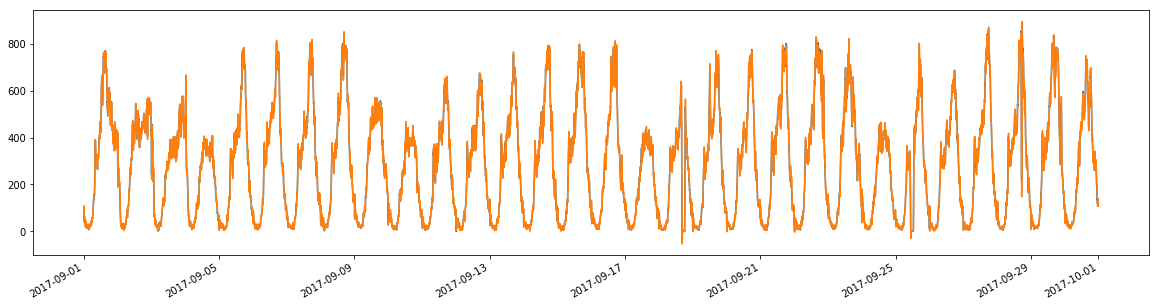

In [87]:
fig, ax = plt.subplots(figsize=(20, 5))
fig.autofmt_xdate()
plt.plot(time[index0:index1], flow[index0:index1])
plt.plot(time[index0:index1], a.fittedvalues[index0:index1])
plt.show()

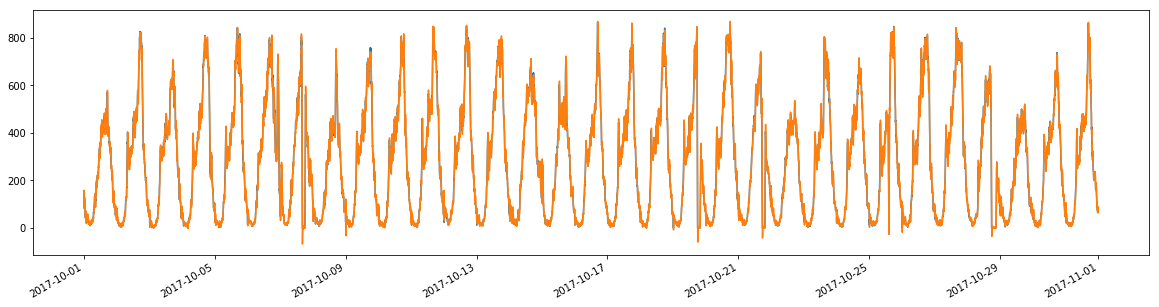

In [88]:
fig, ax = plt.subplots(figsize=(20, 5))
fig.autofmt_xdate()
plt.plot(time[index1:index2], flow[index1:index2])
plt.plot(time[index1:index2], a.fittedvalues[index1:index2])
plt.show()

In [ ]:
cursor.close()
cnx.close()